In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from datasets import load_dataset

In [2]:
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda skills: ast.literal_eval(skills) if pd.notna(skills) else skills)

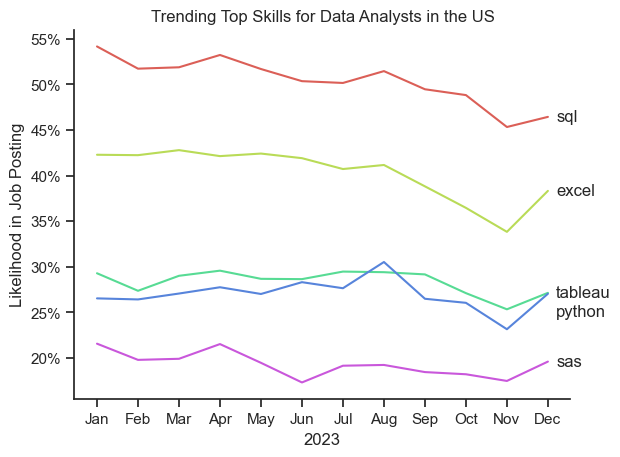

In [94]:
import math
from matplotlib.ticker import PercentFormatter

df_DA_US = df[(df['job_country'] == 'United States') & (df['job_title_short'] == 'Data Analyst')].copy()
df_DA_US['job_posted_month_no'] = df_DA_US['job_posted_date'].dt.month
df_DA_US_explode = df_DA_US.explode('job_skills') 

df_DA_US_pivot = df_DA_US_explode.pivot_table(
    index='job_posted_month_no',
    columns='job_skills',
    aggfunc='size',
    fill_value=0
)

df_DA_US_pivot.loc['Total'] = df_DA_US_pivot.sum()
df_DA_US_pivot = df_DA_US_pivot[df_DA_US_pivot.loc['Total'].sort_values(ascending=False).index]
df_DA_US_pivot = df_DA_US_pivot.drop('Total')

jobs_total = df_DA_US.groupby('job_posted_month_no').size()
df_DA_US_pivot = df_DA_US_pivot.div(jobs_total/100, axis=0)

df_DA_US_pivot = df_DA_US_pivot.reset_index()
df_DA_US_pivot['job_posted_month'] = df_DA_US_pivot['job_posted_month_no'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
df_DA_US_pivot = df_DA_US_pivot.set_index('job_posted_month').drop(columns='job_posted_month_no')

df_plot = df_DA_US_pivot.iloc[:, :5]

sns.set_theme(style='ticks')

sns.lineplot(data=df_plot, dashes=False, legend=False, palette='hls')
sns.despine()
plt.title('Trending Top Skills for Data Analysts in the US')
plt.ylabel('Likelihood in Job Posting')
plt.xlabel('2023')

last_values = df_plot.iloc[-1, :]

offsets = {}

for i, val in enumerate(last_values):
    floored = math.floor(val)
    if floored not in offsets:
        offsets[floored] = 0
    else:
        offsets[floored] += 2

    y = val - offsets[floored]
    plt.text(11.2, y, df_plot.columns[i], va='center')

plt.gca().yaxis.set_major_formatter(PercentFormatter(decimals=0))

